In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras import regularizers

In [6]:
%matplotlib notebook

In [9]:
train_images = np.load("../train_images.npy")
train_images = np.reshape(train_images, (50_000, 28, 28))

with open('../train_labels.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    train_labels = np.array(list(reader))[1:,1]
    
labels = np.zeros((10, 10))
for i in range(10):
    labels[i, i] = 1

train_labels = np.array([labels[int(x), :] for x in train_labels])

<IPython.core.display.Javascript object>


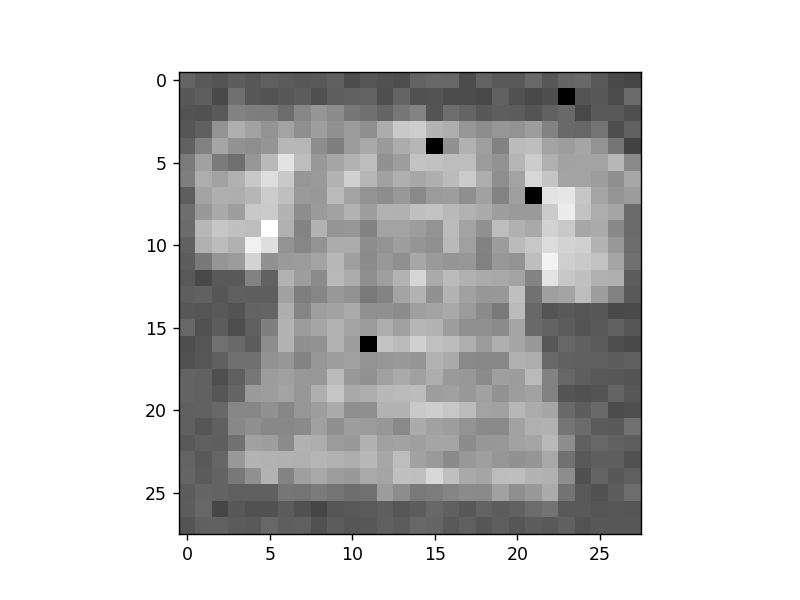

In [10]:

def to_image(idx):
    return np.reshape(train_images[idx], (28, 28)).astype(np.uint8)

def show_image(arr):
    two_d = np.reshape(arr, (28, 28)).astype(np.uint8)
    plt.figure()
    plt.imshow(two_d, cmap='gray', interpolation='nearest')
    plt.show()

show_image(train_images[0])

In [11]:
def find_holes(im, threshold=100):
    kernel = [[1, 1, 1], [1, -8, 1], [1, 1, 1]]
    conv = convolve2d(im, kernel, mode='same')
    max_diff = np.max(conv)
    return np.maximum(0, np.minimum(255, 255 * conv / max_diff)) > threshold
    
def fix_holes(im, holes=None, threshold=100):
    if holes is None:
        holes = find_holes(im, threshold)
        
    kernel = 1/8 * np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    conv = convolve2d(im, kernel, mode='same')
    result = np.array(im)
    result[holes] = conv[holes].flatten()
    result[result < 100] = 0
    return result.flatten()

train_images_no_holes = np.array([fix_holes(im) for im in train_images])


In [12]:
valid_x = train_images_no_holes[:10_000, :]
valid_y = train_labels[:10_000, :]

train_x = train_images_no_holes[10_000:, :]
train_y = train_labels[10_000:, :]

In [13]:
model = Sequential()

model.add(Dense(units=600, activation='sigmoid', input_dim=784, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(units=400, activation='sigmoid', input_dim=200, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(learning_rate=0.06, rho=0.95),
              metrics=[keras.metrics.BinaryAccuracy()])

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
for epoch in range(10):
    model.fit(train_x, train_y, epochs=1, batch_size=256)
    loss_and_metrics = model.evaluate(valid_x, valid_y, batch_size=256)
    print("Validation Accuracy: {:.3f}".format(100 * loss_and_metrics[1]))

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
10000/10000 [==============================] - 0s 22us/step
Validation Accuracy: 90.783
Epoch 1/1
10000/10000 [==============================] - 0s 20us/step
Validation Accuracy: 92.972
Epoch 1/1
10000/10000 [==============================] - 0s 20us/step
Validation Accuracy: 94.179
Epoch 1/1
10000/10000 [==============================] - 0s 21us/step
Validation Accuracy: 94.716
Epoch 1/1
10000/10000 [==============================] - 0s 21us/step
Validation Accuracy: 94.977
Epoch 1/1
10000/10000 [==============================] - 0s 21us/step
Validation Accuracy: 95.123
Epoch 1/1
10000/10000 [==============================] - 0s 20us/step
Validation Accuracy: 95.312
Epoch 1/1
10000/10000 [==============================] - 0s 21us/step
Validation Accuracy: 95.429
Epoch 1/1
10000/10000 [==============================] - 0s 20us/step
Validation Accuracy: 95.569
Epoch 1/1
10000/10000 [==============================] - 0s 20us/step


In [138]:
loss_and_metrics = model.evaluate(valid_x, valid_y, batch_size=256)
print(loss_and_metrics)

10000/10000 [==============================] - 0s 28us/step
[2.6495504497528075, 0.9565500020980835]


In [16]:
test_images = np.load("../test_images.npy")
test_images = np.reshape(test_images, (-1, 28, 28))
print(test_images.shape)

(20000, 28, 28)


In [17]:
test_images_no_holes = np.array([fix_holes(im) for im in test_images])

In [143]:
#show_image(test_images[0])
#show_image(test_images_no_holes[0])

In [18]:
classes = model.predict(test_images_no_holes).argmax(axis=1)
print(classes.shape)

(20000,)


In [19]:
with open('submission.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['ID', 'label'])
    for idx, val in enumerate(classes):
        writer.writerow([str(idx), str(val)])

# Convolutional Neural Network

In [38]:
model2 = Sequential()

model2.add(Conv2D(filters=32, kernel_size=3, activation='sigmoid', 
                  input_shape=(28, 28, 1)))

model2.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model2.add(Conv2D(filters=40, kernel_size=3, activation='sigmoid'))

model2.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model2.add(Conv2D(filters=48, kernel_size=3, activation='sigmoid'))

model2.add(Flatten())
model2.add(Dense(units=10, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.1),
              metrics=[keras.metrics.BinaryAccuracy()])

In [39]:
train_x_conv = train_x.reshape((-1, 28, 28, 1)) / 255
valid_x_conv = valid_x.reshape((-1, 28, 28, 1)) / 255

In [40]:
for epoch in range(10):
    model2.fit(train_x_conv, train_y, epochs=1, batch_size=64)
    loss_and_metrics = model2.evaluate(valid_x_conv, valid_y, batch_size=256, verbose=False)
    print("Validation Accuracy: {:.3f}".format(100 * loss_and_metrics[1]))

Epoch 1/1
12864/40000 [========>.....................] - ETA: 12s - loss: 2.3273 - binary_accuracy: 0.9000

KeyboardInterrupt: 

In [206]:
loss_and_metrics = model2.evaluate(valid_x_conv, valid_y, batch_size=256)
print(loss_and_metrics)

10000/10000 [==============================] - 3s 253us/step
[1.3589767217636108, 0.931679904460907]


In [227]:
test_images_no_holes_conv = test_images_no_holes.reshape((-1, 28, 28, 1)) / 255
classes = model2.predict(test_images_no_holes_conv).argmax(axis=1)
with open('submission2.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['ID', 'label'])
    for idx, val in enumerate(classes):
        writer.writerow([str(idx), str(val)])

In [207]:
print(model2.predict(test_images_no_holes_conv)[0, :])

[0.17064887 0.06433936 0.13838695 0.09810541 0.10076405 0.0478199
 0.23354475 0.02984181 0.10254013 0.01400881]


In [229]:
classes2 = classes
classes1 = model.predict(test_images_no_holes).argmax(axis=1)

count = 0
for x, y in zip(classes1, classes2):
    if x != y:
        count += 1
    
    
print(count)

5803


In [224]:
print((classes2 == 9).sum())

4060


In [228]:
classes

array([9, 5, 2, ..., 3, 8, 2], dtype=int64)